## Challenge Description


The company of this exercise is a social network. They decided to add a feature called: Recommended Friends, i.e. they suggest you people you may know.

A data scientist has built a model to suggest 5 people to each user. These potential friends will be shown on the user newsfeed. At first, the model is tested just on a subset of users to see how it performs compared to the newsfeed without the new feature.

The test has been running for some time and your boss asks you to check the results. You are asked to check, for each user, the number of pages visited during their first session since the test started. If this number increased, the test is a success.

Specifically, your boss wants to know:

- Is the test winning? That is, should 100% of the users see the Recommended Friends feature?
- Is the test performing similarly for all user segments or are there differences among different segments?
- If you identified segments that responded differently to the test, can you guess the reason? Would this change your conclusions?

---

## Load data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
user = pd.read_csv('user_table.csv')
test = pd.read_csv('test_table.csv')

In [3]:
test.head(3)

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8


In [4]:
user.head(3)

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01


In [29]:
# check the start time of the experiment
test.groupby('test').agg({'date':'min'})

,date
test,
0,2015-08-01
1,2015-08-01


In [10]:
print(len(test))
print(len(user))

100000
100000


In [11]:
# any difference in users between two tables?
test[~test.user_id.isin(user.user_id.unique())]

,user_id,date,browser,test,pages_visited


In [15]:
# join two tables
data = pd.merge(test, user, on='user_id',how='inner')

In [16]:
# define users signup after the start date('2015-08-01') of the experiment as new users
data['new_user'] = 0
data.loc[data[data['signup_date']>='2015-08-01'].index, 'new_user'] = 1
data.head()

,user_id,date,browser,test,pages_visited,signup_date,new_user
0,600597,2015-08-13,IE,0,2,2015-01-19,0
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,0
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,0
3,5990330,2015-08-27,Safari,0,8,2015-06-25,0
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,0


In [18]:
# check missing values
import cufflinks as cf
cf.go_offline()
data.count().iplot(kind = 'bar')

In [22]:
# check user distributions in different segments
data.groupby('test').browser.value_counts().unstack()

browser,Chrome,Firefox,IE,Opera,Safari
test,,,,,
0,21453,10972,10906,1109,5406
1,21974,10786,10974,1018,5402


In [23]:
data.groupby('test').new_user.value_counts().unstack()

new_user,0,1
test,,
0,39890,9956
1,40109,10045


In [27]:
# check the pages vistied for two groups
data.groupby('test').pages_visited.mean().to_frame('pages visited')

,pages visited
test,
0,4.608394
1,4.599693


---

<font size=4>Question 1: Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

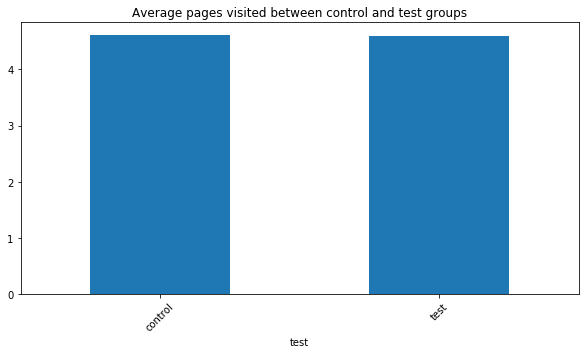

In [42]:
plt.figure(figsize=(10,5))
data.groupby('test').pages_visited.mean().plot(kind='bar')
plt.xticks([0,1],['control','test'],rotation=45)
plt.title('Average pages visited between control and test groups')
plt.show()

In [43]:
stat, p = stats.ttest_ind(data[data['test']==0]['pages_visited'],
                          data[data['test']==1]['pages_visited'],equal_var=False)
diff = data[data['test']==1]['pages_visited'].mean() - data[data['test']==0]['pages_visited'].mean()
print('diff:',diff)
if p < 0.05:
    print('pvalue:',p, '\nSignificant!')
else:
    print('pvalue:',p,'\nNot significant!')

diff: -0.008700907340286612
pvalue: 0.5774523171559118 
Not significant!


<font size=3>The above result shows that the test is not winning, there is no statistical significance showing that there is a difference between control and test groups. So the new feature should not be released to all users.

---

<font size=4>Question 2: Is the test performing similarly for all user segments or are there differences among different segments?

<font size=3> 2.1 For different browsers

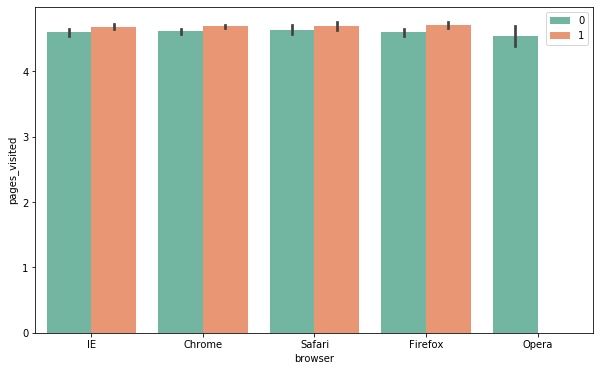

In [62]:
plt.figure(figsize=(10,6))
sns.barplot(data['browser'],data['pages_visited'],hue=data['test'], palette='Set2')
plt.legend(loc=0)
plt.show()

In [69]:
t_browser = data.groupby(['test','browser']).pages_visited.mean().unstack()
t_browser

browser,Chrome,Firefox,IE,Opera,Safari
test,,,,,
0,4.613341,4.600164,4.598478,4.546438,4.638180
1,4.690680,4.714259,4.685985,0.000000,4.692336


In [73]:
print('{0:10s} {1:>15s} {2:>10s}'.format('Country','Difference', 'P-Value'))
print('-' * 40)
for col in data.browser.unique():
    cont = data[(data['browser'] == col)&(data['test']==0)]['pages_visited']
    exp = data[(data['browser']==col)&(data['test']==1)]['pages_visited']
    result = stats.ttest_ind(cont, exp, equal_var=False)
    diff = exp.mean() - cont.mean()
    print('{0:10s} {1:15f} {2:10f}'.format(col, diff, result.pvalue))

Country         Difference    P-Value
----------------------------------------
IE                0.087507   0.007830
Chrome            0.077339   0.000943
Safari            0.054156   0.241174
Firefox           0.114095   0.000582
Opera            -4.546438   0.000000


### From the above results, we can see that:
- there is a significant increase in pages visited per user for IE, Chrome, and Firefox users. 
- there may be a data capture bug in Opera browser, and we may need to check it with engineers.
- there is a increase in Safari, but not significant

<font size=3>2.2 For new users and experienced users

In [63]:
data.groupby(['test','new_user']).pages_visited.mean().unstack()

new_user,0,1
test,,
0,4.603284,4.628867
1,4.622379,4.509109


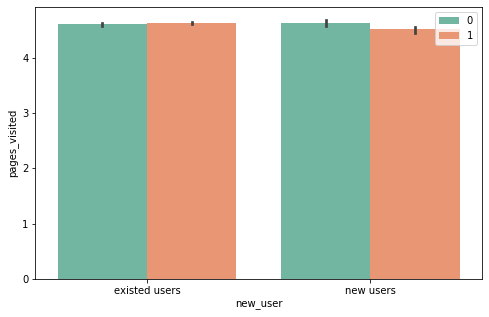

In [67]:
plt.figure(figsize=(8,5))
sns.barplot(data['new_user'],data['pages_visited'],hue=data['test'], palette='Set2')
plt.xticks([0,1],['existed users','new users'])
plt.legend(loc=1)
plt.show()

In [78]:
print('{0:10s} {1:>15s} {2:>10s}'.format('New Users','Difference', 'P-Value'))
print('-' * 40)
for col in data.new_user.unique():
    cont = data[(data['new_user'] == col)&(data['test']==0)]['pages_visited']
    exp = data[(data['new_user']==col)&(data['test']==1)]['pages_visited']
    result = stats.ttest_ind(cont, exp, equal_var=False)
    diff = exp.mean() - cont.mean()
    print('{0:10f} {1:15f} {2:10f}'.format(col, diff, result.pvalue))

New Users       Difference    P-Value
----------------------------------------
  0.000000        0.019095   0.261837
  1.000000       -0.119758   0.001742


### From the above results, we can see that:

- for experienced users, there is a increase in pages visited but not significant.
- for new users, the new recommendation feature drops their average pages visited significant! We may need to dive deeper to figure out the reason

---

<font size=4>Question 3: If you identified segments that responded differently to the test, can you guess the reason? Would this change your conclusions?

- For different browsers:
  - the reason of the Opera goes to zero in test group could be a bug in the setup of the experiment, which may lead that data from the Opera users can not be captured.
  - And the different behaviors between different browsers could be due to the difference of the UI, which may generate different user experience.

In [79]:
# let's filter out the Opera data and re-analyze the results
df = data[data['browser']!='Opera']

In [80]:
df.groupby('test').pages_visited.mean()

test
0    4.609804
1    4.694989
Name: pages_visited, dtype: float64

In [81]:
stats, p = stats.ttest_ind(df[df['test']==0]['pages_visited'],
                          df[df['test']==1]['pages_visited'])
print('pvalue: ',p)

pvalue:  4.273456891094664e-08


In [82]:
# for new users and experienced users
df.groupby(['test','new_user']).pages_visited.mean().unstack()

new_user,0,1
test,,
0,4.603481,4.635149
1,4.720415,4.593712


In [85]:
print('{0:10s} {1:>15s} {2:>10s}'.format('New Users','Difference', 'P-Value'))
print('-' * 40)
for col in df.new_user.unique():
    cont = df[(df['new_user'] == col)&(df['test']==0)]['pages_visited']
    exp = df[(df['new_user']==col)&(df['test']==1)]['pages_visited']
    result = stats.ttest_ind(cont, exp, equal_var=False)
    diff = exp.mean() - cont.mean()
    print('{0:10f} {1:15f} {2:10f}'.format(col, diff, result.pvalue))

New Users       Difference    P-Value
----------------------------------------
  0.000000        0.116933   0.000000
  1.000000       -0.041437   0.279739


### From the above results, we can see that after filter out the Opera data, there is a significant increase for experienced users, and the decrease for new users are not significant.

#### The different behaviors between experienced users and new users could be:
  - the friend recommendation model may be based on a user's previous social activity on the site. then for new users, since they don't have any previous history for recommendation model to use, the recommendation result is like a random guess, which cannot draw new user's interest. But the recommended friends may occupy some space on the page, so it may even decrease the #page_visited for new users a little bit.